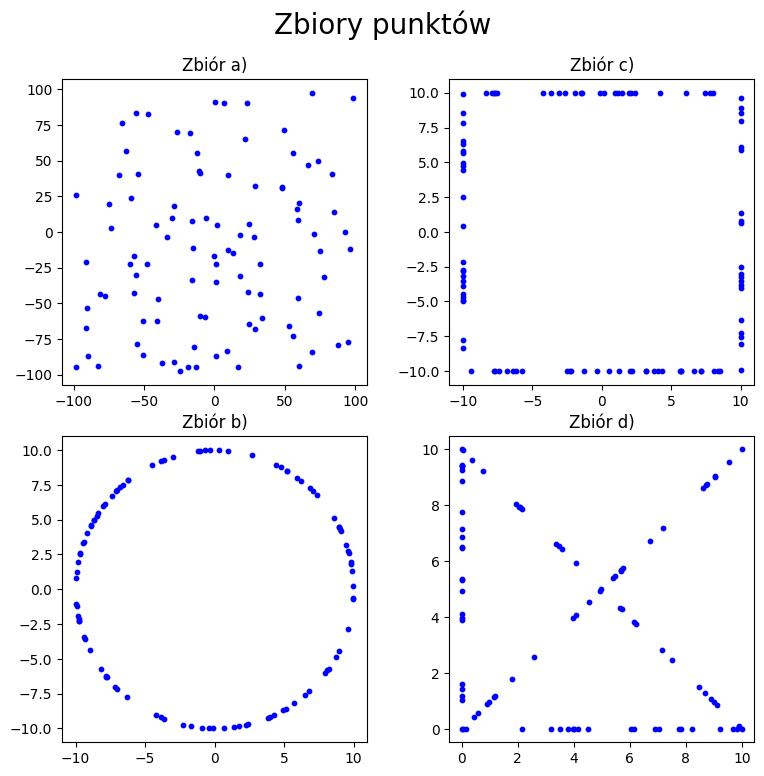

Generating data took: 0.000s.


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
import math
import time
from functools import *


# helper functions/setting up
np.random.seed(2)

def lerp(start, end, t):
    return start + (end - start) * t

data = []

# generowanie 1a
def generate_set_a(start, stop, count):
    return np.random.uniform(start, stop, [count, 2])

# generowanie 1b
def generate_set_b(center, radius, count):
    return np.array([[center[0] + radius*math.sin(angle),  center[1] + radius*math.cos(angle)]
                    for angle in np.random.uniform(0, 2*math.pi, count)])

# generowanie 1c
def generate_set_c(lower_left, upper_right, count):
    ll, ur, arr = lower_left, upper_right, [[] for _ in range(count)]
    for i in range(count):
        s = random.randint(0, 3)
        t = random.random()

        # dolna krawędz
        if s == 0:
            arr[i] = [lerp(ll[0], ur[0], t), ll[1]]
        
        # prawa krawędz
        if s == 1:
            arr[i] = [ur[0], lerp(ll[1], ur[1], t)]
        
        # górna krawędz
        if s == 2:
            arr[i] = [lerp(ll[0], ur[0], t), ur[1]]
        
        # lewa krawędz
        if s == 3:
            arr[i] = [ll[0], lerp(ll[1], ur[1], t)]
    
    return np.array(arr)


# generowanie 1d
def generate_set_d(side, side_count, diagonal_count):
    arr = [[] for _ in range(2*(side_count + diagonal_count))]

    # oś ox
    for i in range(side_count):
        arr[i] = [random.random()*side, 0]
    
    # oś oy
    for i in range(side_count):
        arr[i + side_count] = [0, random.random()*side]
    
    # przekątna 1
    for i in range(diagonal_count):
        x = random.random() * side
        arr[i + 2*side_count] = [x, x]
    
    # przekątna 2
    for i in range(diagonal_count):
        x = random.random() * side
        arr[i + 2*side_count + diagonal_count] = [x, side - x]
    
    # dodanie wierzcgołków krawadratu
    arr.append([0, 0])
    arr.append([side, 0])
    arr.append([0, side])
    arr.append([side, side])

    return np.array(arr)

# dodanie zbiorów do zbioru data oraz pomiar czasu
generation_start = time.time()

data.append(generate_set_a(-100, 100, 100))
data.append(generate_set_b([0, 0], 10, 100))
data.append(generate_set_c([-10, -10], [10, 10], 100))
data.append(generate_set_d(10, 20, 25))

generation_stop = time.time()


# Tworzenie wykresu
matplotlib.rcParams['figure.figsize'] = [8, 8]
figure, axis = plt.subplots(2, 2)
plt.axis("equal")
for i, data_set in enumerate(data):
    axis[i%2, i//2].scatter(*zip(*data_set), color="blue", s=10)

figure.suptitle('Zbiory punktów', fontsize=20)
figure.tight_layout(pad=2)
axis[0, 0].set_title("Zbiór a)")
axis[0, 1].set_title("Zbiór c)")
axis[1, 0].set_title("Zbiór b)")
axis[1, 1].set_title("Zbiór d)")

# zapisywanie jako jpg
# plt.savefig('images/sets_vis.png', dpi=500)
plt.show()
print(f"Generating data took: {generation_stop - generation_start :.3f}s.")

CONFIGURE

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in self.scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in self.scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])

In [4]:
# implementacja algorytmów bez wizualizacji
from functools import reduce, cmp_to_key

eps = 10**(-10)

# zwraca odleglosc ^2 miedzy punktami a i b
def length_2(a, b):
    return (a[0] - b[0])*(a[0] - b[0]) + (a[1] - b[1])*(a[1] - b[1])

# wyznacznik 2x2 okreslajacy polozenie punktu c wzgledem  prostej przechodzącej przez a i b
def det(a, b, c):
    return (a[0] - c[0])*(b[1] - c[1]) - (b[0] - c[0])*(a[1] - c[1])

# funkcja pomocnicza dla określaniawypukłości kąta
def orient(a, b, c):
    d = det(a, b, c)
    if d > eps:
        return 1
    elif d < -eps:
        return -1
    else:
        return 0

# komparator dla sortowania w grahamsie
def grahams_cmp(a, b, c):
    val = orient(a, b, c)
    if orient(a, b, c):
        return val
    if length_2(a, b) >= length_2(a, c):
        return 1
    return -1

# funkcja zwracajaca ten z punktów b i c, ktory tworzy mniejszy kąt z a z osia ox dodatkowo warunek na wieksza odleglosc przy wpołliniowości
def min_angle(a, b, c):
    # możemy użyc porownania liczb zaa pomocą == ponieważ sprawdzamy czy a = b lub a = c
    if a[0] == b[0] and a[1] == b[1]:
        return c
    if a[0] == c[0] and a[1] == c[1]:
        return b
        
    d = det(a, b, c)

    if d == 0:
        if length_2(a, b) >= length_2(a, c):
            return b
        else:
            return c
    if d < 0:
        return b
    return c

def grahams_without_wiz(points):
    
    points = points.tolist()

    # znajduje punkt z min y oraz min x
    points.sort(key=lambda x:[x[1], x[0]])

    start = points.pop(0)

    # posortowanie punktów komparatorem dla grahamsa
    points.sort(key= cmp_to_key(lambda x, y : grahams_cmp(start, y, x)))

    # dodanie trzech ttrzech pierwszych punktów do otoczki
    hull = [start] + points[:2]

    i = 2
    while i < len(points):            
        if orient(hull[-2], hull[-1], points[i]) == 0:
            hull.pop()
            hull.append(points[i])
            i = i + 1    
        elif orient(hull[-2], hull[-1], points[i]) == 1:
            hull.append(points[i])
            i = i + 1
        else:
            hull.pop()

    # musimy sprawdzić, czy ostatni punkt nie jest kolinearny z 1 i przedostatnim, jezeli tak to usuwamy
    if orient(hull[-2], hull[-1], hull[0]) == 0:
        hull.pop()

    return hull

def jarvis_without_wiz(points):
    
    points = points.tolist()

    # znajduje punkt początkowy
    start = min(points, key=lambda x: [x[1], x[0]])
    hull = [start]
    
    while True:
        # znajduje punkt z najmniejszym katem pomiedzy start, a osią ox
        point = reduce(lambda a, b: min_angle(start, a, b), points)
        start = point
        if hull[0] == point:
            break
        hull.append(point)
    
    return hull

Liczba punktów w otoczce zbioru 0: 11
Liczba punktów w otoczce zbioru 1: 100
Liczba punktów w otoczce zbioru 2: 8
Liczba punktów w otoczce zbioru 3: 4
Jarvis took:  0.005984306335449219
Grahams took:  0.001993894577026367


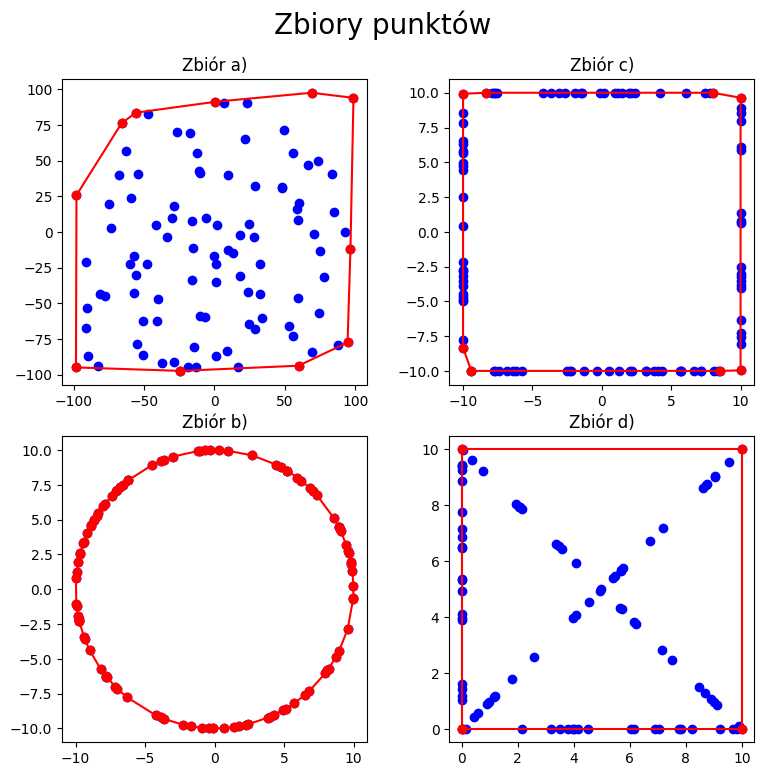

In [5]:
# Utworzenie wizualizacji otoczek, jako, że jest taka sama dla jarvisa i grahamsaa to tworze tylko jedną
matplotlib.rcParams['figure.figsize'] = [8, 8]
figure, axis = plt.subplots(2, 2)
plt.axis("equal")

# przechowuje otoczki dla odpowiadajacych zbiorów punktów
HULLS = []

for i, data_set in enumerate(data):

    points = data_set
    convex_hull = jarvis_without_wiz(points)
    HULLS.append(convex_hull)
    print("Liczba punktów w otoczce zbioru ", i, ": ", len(convex_hull), sep="")

    # na potrzebę rysowania musimy dodać punkt zerowy, aby narzedzie do rysowania zamkneło wielokąt
    convex_hull.append(convex_hull[0])

    for point in points:
        axis[i%2, i//2].scatter(point[0], point[1], c="b")
    
    axis[i%2, i//2].plot(*zip(*convex_hull), "-ro")

figure.suptitle('Zbiory punktów', fontsize=20)
figure.tight_layout(pad=2)
axis[0, 0].set_title("Zbiór a)")
axis[0, 1].set_title("Zbiór c)")
axis[1, 0].set_title("Zbiór b)")
axis[1, 1].set_title("Zbiór d)")

# pomiar czasu dla zbiorów z treści zadania
cum_time = 0

# jarvis
for data_set in data:
    points = data_set
    st = time.time()
    convex_hull = jarvis_without_wiz(points)
    cum_time += time.time() - st

print("Jarvis took: ", cum_time)
cum_time = 0

# grahams
for data_set in data:
    points = data_set
    st = time.time()
    convex_hull = grahams_without_wiz(points)
    cum_time += time.time() - st

print("Grahams took: ", cum_time)


# save plot
# plt.savefig('images/line.png', dpi=500)
plt.show()

In [6]:
# Algorytmy z wizualizacją działania

def jarvis_with_wiz(points):
    
    points = points.tolist()

    # znajduje punkt początkowy
    start = min(points, key=lambda x: [x[1], x[0]])
    hull = [start]
    scenes = []
    
    while True:
        scenes.append(Scene([PointsCollection(points, "blue"), PointsCollection(hull, 'red', marker = "o")], [LinesCollection([[hull[i], hull[i+1]] for i in range(len(hull)-1)], 'red')]))
        
        # znajduje punkt z najmniejszym katem pomiedzy start, a osią ox
        point = reduce(lambda a, b: min_angle(start, a, b), points)
        start = point
        if hull[0] == point:
            break
        hull.append(point)
    
        scenes.append(Scene([PointsCollection(points, "blue"), PointsCollection(hull, 'red', marker = "o")], [LinesCollection([[hull[i], hull[i+1]] for i in range(len(hull)-1)], 'red')]))
    
    hull.append(hull[0])
    scenes.append(Scene([PointsCollection(points, "blue"), PointsCollection(hull, 'red', marker = "o")], [LinesCollection([[hull[i], hull[i+1]] for i in range(len(hull)-1)], 'red')]))
    
    return scenes

def grahams_with_wiz(points):
    
    points = points.tolist()
    scenes = []

    # znajduje punkt z min y oraz min x
    points.sort(key=lambda x:[x[1], x[0]])

    start = points.pop(0)

    # posortowanie punktów komparatorem dla grahamsa
    points.sort(key= cmp_to_key(lambda x, y : grahams_cmp(start, y, x)))

    # dodanie trzech ttrzech pierwszych punktów do otoczki
    hull = [start] + points[:2]

    i = 2
    while i < len(points):            
        if orient(hull[-2], hull[-1], points[i]) == 0:
            hull.pop()
            hull.append(points[i])
            i = i + 1    
        elif orient(hull[-2], hull[-1], points[i]) == 1:
            hull.append(points[i])
            i = i + 1
        else:
            hull.pop()
        
        scenes.append(Scene([PointsCollection(points, "blue"), PointsCollection(hull, 'red', marker = "o")], [LinesCollection([[hull[i], hull[i+1]] for i in range(len(hull)-1)], 'red')])) 

    # musimy sprawdzić, czy ostatni punkt nie jest kolinearny z 1 i przedostatnim, jezeli tak to usuwamy
    if orient(hull[-2], hull[-1], hull[0]) == 0:
        hull.pop()
    
    scenes.append(Scene([PointsCollection(points, "blue"), PointsCollection(hull, 'red', marker = "o")], [LinesCollection([[hull[i], hull[i+1]] for i in range(len(hull)-1)], 'red')])) 

    return scenes

In [7]:
%matplotlib notebook
method = "J" # G dla grahamsa J dla jarvisa
data_set_number = 1 # numer zbioru odopowiednio 0 - a, 1 - b, 2 - c, 3 - d

if method == "G":
    viz = Plot(grahams_with_wiz(data[data_set_number]))
elif method == "J":
    viz = Plot(jarvis_with_wiz(data[data_set_number]))
viz.draw()

<IPython.core.display.Javascript object>

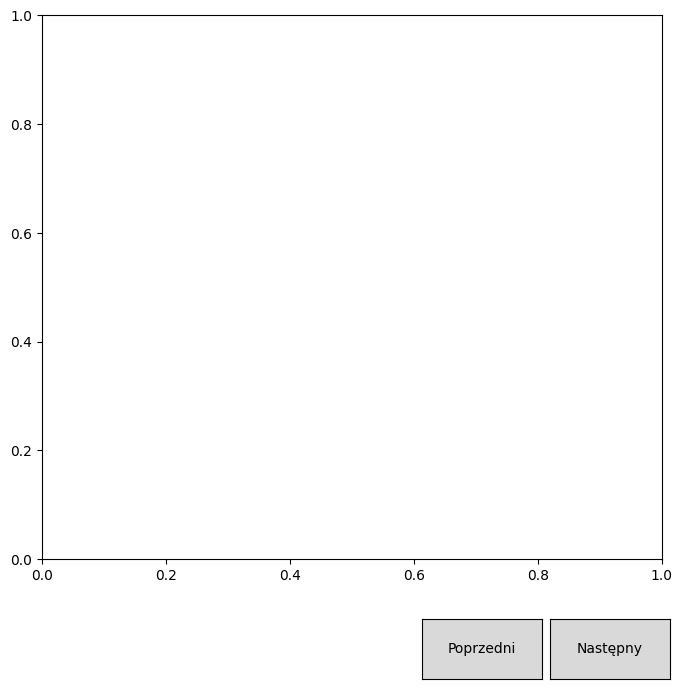

<Figure size 800x800 with 0 Axes>

In [8]:
# wizualizacja otoczki dla wiekszych zbiorów, zajmuje dosyć dlugo
gen_big_data = False
if gen_big_data:
    big_data = []

    big_data.append(generate_set_a(-1000, 1000, 10 ** 3))
    big_data.append(generate_set_b([0, 0], 100, 10 ** 3))
    big_data.append(generate_set_c([-100, -100], [100, 100], 10 ** 3))
    big_data.append(generate_set_d(100, 10**2, 10**2))

    matplotlib.rcParams['figure.figsize'] = [8, 8]
    figure, axis = plt.subplots(2, 2)
    plt.axis("equal")

    for i, data_set in enumerate(big_data):

        points = data_set
        convex_hull = grahams_without_wiz(points)
        convex_hull.append(convex_hull[0])

        for point in points:
            axis[i%2, i//2].scatter(point[0], point[1], c="b", s=0.4)

        axis[i%2, i//2].plot(*zip(*convex_hull), "-ro")


    figure.suptitle('Zbiory punktów', fontsize=20)
    figure.tight_layout(pad=2)
    axis[0, 0].set_title("Zbiór a')")
    axis[0, 1].set_title("Zbiór c')")
    axis[1, 0].set_title("Zbiór b')")
    axis[1, 1].set_title("Zbiór d')")

    # plt.savefig('images/big_sets.png', dpi=500)
    plt.show()


In [21]:
# TESTOWANIE CZASÓW

# ROZKLAD JEDNOSTAJNY
DATA1 = generate_set_a(-1000, 1000, 10**2)
print("SET 1: " + 20*'-')

A = time.time()
grahams_without_wiz(DATA1)
print("Grahams took:", time.time() - A)

B = time.time()
jarvis_without_wiz(DATA1)
print("Jarvis took:", time.time() - B)

# JEDNOSTAJNY OKRAG
DATA2 = generate_set_b([0, 0], 1000, 10**1)
print("SET 2: " + 20*'-')

A = time.time()
grahams_without_wiz(DATA2)
print("Grahams took:", time.time() - A)

B = time.time()
jarvis_without_wiz(DATA2)
print("Jarvis took:", time.time() - B)

# PROSTOKAT
DATA3 = generate_set_c([-100, -100], [100, 100], 10**1)
print("SET 3: " + 20*'-')

A = time.time()
grahams_without_wiz(DATA3)
print("Grahams took:", time.time() - A)

B = time.time()
jarvis_without_wiz(DATA3)
print("Jarvis took:", time.time() - B)

# KWADRAT + PRZEKATNE
DATA4 = generate_set_d(30, 10**2, 10**2)
print("SET 4: " + 20*'-')

A = time.time()
grahams_without_wiz(DATA4)
print("Grahams took:", time.time() - A)

B = time.time()
jarvis_without_wiz(DATA4)
print("Jarvis took:", time.time() - B)

SET 1: --------------------
Grahams took: 0.0009975433349609375
Jarvis took: 0.0009975433349609375
SET 2: --------------------
Grahams took: 0.0
Jarvis took: 0.0
SET 3: --------------------
Grahams took: 0.0
Jarvis took: 0.0009968280792236328
SET 4: --------------------
Grahams took: 3.4580647945404053
Jarvis took: 1.145052433013916
